In [29]:
include("../scripts/robot.jl")

In [2]:
using Distributions
using LinearAlgebra

In [3]:
mutable struct Particle
    pose
end

In [4]:
function motion_update(self::Particle, nu, omega, time, noise_rate_pdf)
    ns = rand(noise_rate_pdf)
    noised_nu = nu + ns[1]*sqrt(abs(nu)/time) + ns[2]*sqrt(abs(omega)/time)
    noised_omega = omega + ns[3]*sqrt(abs(nu)/time) + ns[4]*sqrt(abs(omega)/time)
    self.pose = state_transition(IdealRobot([]), noised_nu, noised_omega, time, self.pose)
end

motion_update (generic function with 1 method)

In [5]:
mutable struct Mcl
    particles
    motion_noise_rate_pdf
end

In [6]:
function Mcl_(init_pose, num, motion_noise_stds)
    self = Mcl(ntuple(x->nothing, fieldcount(Mcl))...)
    self.particles =[Particle(init_pose) for i in 1:num]
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    return self
end

Mcl_ (generic function with 1 method)

In [32]:
function motion_update(self::Mcl, nu, omega, time)
    for p in self.particles
        motion_update(p, nu, omega, time, self.motion_noise_rate_pdf)
    end
end

motion_update (generic function with 2 methods)

In [33]:
function draw(self::Mcl, ax, elems)
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3]) for p in self.particles]
    vys = [sin(p.pose[3]) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))
end

draw (generic function with 7 methods)

In [34]:
mutable struct EstimationAgent <: AbstractAgent
    nu
    omega
    estimator
    time_interval
    prev_nu
    prev_omega
end

In [35]:
function  EstimationAgent_(time_interval, nu, omega,estimator)
    self = EstimationAgent(ntuple(x->nothing, fieldcount(EstimationAgent))...)
    self.nu = nu
    self.omega = omega
    self.estimator = estimator
    self.time_interval = time_interval
    self.prev_nu = 0.0
    self.prev_omega = 0.0
    return self
end

EstimationAgent_ (generic function with 1 method)

In [36]:
function decision(self::EstimationAgent, observation=nothing)
    motion_update(self.estimator, self.prev_nu, self.prev_omega, self.time_interval)
    self.prev_nu, self.prev_omega = self.nu, self.omega
    return self.nu, self.omega
end

decision (generic function with 6 methods)

In [37]:
function draw(self::EstimationAgent, ax, elems)
    draw(self.estimator, ax, elems)
end

draw (generic function with 7 methods)

In [38]:
initial_pose = [0.0, 0.0, 0.0]
estimator = Mcl_(initial_pose, 100, Dict("nn"=>0.01, "no"=>0.02, "on"=>0.03, "oo"=>0.04))
a = EstimationAgent_(0.1, 0.2, 10.0/180*pi, estimator)
motion_update(estimator, 0.2, 10.0/180*pi, 0.1)
for p in estimator.particles
    println(p.pose)
end

[0.018373519539384566, 0.0002139294569504938, 0.023285662821953268]
[0.016783815425419204, 0.0001565978269188009, 0.0186600339692987]
[0.023206723257889295, 0.0002017793407447745, 0.017389293080924056]
[0.02085679554340007, 0.00018310422195522266, 0.01755778040484479]
[0.019988751935656995, 0.0002579680772365667, 0.02580989122728782]
[0.02557284073432023, 0.00022210546483754454, 0.017369981122916555]
[0.0170665424994012, 0.00017539727595919252, 0.020553794195080695]
[0.019790432010726382, 0.0001951420983396227, 0.019720213704973157]
[0.01922698687738834, 7.163211004710378e-5, 0.007451170491358553]
[0.023406634402296532, 0.00014456171443090403, 0.01235204292288535]
[0.02016573633412719, 0.00026705178753273876, 0.02648414851047322]
[0.021478449664733366, 7.378619913141905e-5, 0.006870692253661537]
[0.01713567184353351, 0.00017275412002151492, 0.02016241547835177]
[0.020712939492743186, 0.00028991017124796204, 0.027991318378365743]
[0.014068427529776658, 2.43432572565551e-5, 0.00346068996

In [39]:
function trial(motion_noise_stds)
    time_interval = 1.0
    world = World(30, time_interval)
    initial_pose = [0.0, 0.0, 0.0]
    estimator = Mcl_(initial_pose, 100, motion_noise_stds)
    circling = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, estimator)
    r = Robot_(initial_pose, sensor=nothing, agent=circling, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAYBxtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADXxliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5FnEb6C9gPt3e826oHE1AgcXxvRCBxQI/BeMobygLn0j9VWXolTLRr1nefL0lQJDHRd0bMQ2bwJ+rzm8Mp/b24dtpJKsQryCKzCJcKad8rXWcKOAUajWn2P0NKgXGBFwI0M+idp/QrLQJJggEup5GqdX9LpivTz0Tg/GtPHRN/r0yThMt621zn7a4ylSl42LRaw5MezwM/+4GZwzEqm3AEN61OX4+ROEd9aArigTp3XWPCo1M3arBFgwglcnHb1e8ZbqIj4YaLbonxrArOWHmfSfBqXWPde/WRktmyHhQ5zaphFSjYU0Lns11vXjU1ONMVKVbNEfaKST3u+nzCLmQVjsoOK4fNxLvubsCygriI+/cKxxNVwhwMxig92FhVnxjeW0Qawhd7VT1zV28fRz3/DtwAEYAEMPhuaPHs+eUmorS8OmkrKb/BFyL/+uIgBi9KTpelcn4ZADCZ5v4oynHm5NxE59pKbJ9JAsOPBdsd2kCu71nJq/EQYHSrbPdz4PH+mJYSEYOMqie4UU1lgO5wDyZhNdlPulQzeofOFm1zv7YjSTVXgnqxotN06/hxHfEupEYr4JwU4Vxzm/7S98Zg8N9S7JPyWDhPU3xZQklMgfm/wYdLHCTtRfKP7SjJinBdxNxmZ5Lsj4iGTzD1ATeh9md4XleyTPJcEX42UJYIBb/3FzS4TBMUhQXPKIE3INAIYSVT7KNKE5Nno/rPZFicYk/zri4vwMWbxNc45aAjX4CQNCsesTDLDrqz/seeQH5nRKybNvVqeFP6/tciMZvNsVAMu9MFSz9IqHRoh6W+vIC3Uplbh1KeEe9BPSvlahWUDsuQdaLzbo1Dr4d+hLejubyxoZ5VGaioPBBaYce+dASRA2lvgJIKIblQ9u8rSSllrXRQLzu8vfmhPDiw1ceBWBgDOXooHs2WtpICElmnqPeOvyHHlNGNwgvNNz6jXq0qn+yQMfoh/EWI/8EXHQ72h2WSyrDdkcq/2D8qVpeamBwXGOIkbDmscFhDDxpgjdR17Guw/XI4W2pigJkqqltej87340eyYGSKM+OugygPfCRjnZqg86aE48AyHFZHELf4C4uDEeu2P1ce3epCOWGT0sF1/Yg36V9p9rVGbxnblKeu60eRbeyCWroWorzgn3O4Mpa9BQRCbQofKmmPB9TxGegVHL/3l6kI2iGEr283smLJu8ra6g/ptsa+pWJarEFNRCaJbh3swUzqdtgmup57WFJ+Gm689aB3rg/3pdDOqcOm8cfQWXO6jqPVWuOlvy7oQYka/PFPHP4FoYBw0doG3npn8URigohc6EHFoWJGRp0AbrWfcaSOT/+iHd10jipSM24GT4Jlzqz6OFl/EjbNadjlJB7ollvx1DHSN8aHe9BPOFjB3COm73lbyQ7nDBKMVAWTXdupzCghSWsQ2Wy+e6J0UvDYGvbGf+uOMjZ7wAUIdVPbPgt08ddAXYTqLZKkw0rMgBTIJqSCL3pq8cyVDdwq58HMTm7iAsOPGcM+7j6syvm8+d+z/adX0aQXE9M6NxIIjUro3U3dElV11BPxVrsHXLJEYVzm4MnDkXMy0AGSegI0vzqYqnHSGrGxFzkE+cacrjXGEdPbUPV/7/EHGfYaHvJ1IS0AcZCzTffPytixtlMop+72gJu9If1+gyBa/LZY9YvoMXOQhPV8MFxyoLVHLWSIT/SMIwgS7pK0jwJZLQIfRy43H5sH8Vjfwfnv6NWfQJqsYR+4Y7cg2c+heT9vMQ87jRavEQUK/VIQAY4Lrl1ZY58tEZLCnVAmkufYmqr3ZeRUIGgRw55pKTm6zE1OsjawgE9JMBy6IBBH5DKlh76qVLCAtOtU/kC+KN9zFLs8lCM4Tn9qnb+/jbZF8Lb9sDU4p04MjoIln1Uk4436Oi/vjA1C5WHOBG9BlAEjKcdhlbKFRTFeuWwBAY2hGsX+/vo3wDK+30DCYAFhFI42eDTToI7V7yO++rZO6WLhhktDzSV8tYs8rW/faajj6kekDQb97BxiV6h4vtS5Ul461ZbnJN/ABy8cd3wHMvTrwuA5Xl+jDM8hDVxCdSh1c6xqDwjhVbE+qfVbj+ZNZe9/6OIjm16kM2XvAS5/xuJaj4p29TPX7rRuI/SCntKPOtKyLlYlSnZm/6O0SA6fZjgTQ4XlQ62mfc6CMrDuLU+9Iu2jfPzHoMkTxvNomNuA8TKwiFA45oAM6BLUh4AiubXm/gmdkAAAMAAAR/PDg9Z3xRLYxTM5gJoo1U8KysumdVXxcUWXBjX0MDI509plK/+4QZOuGfghdW88N05Qsj0w85/sfpyVQaqI+XhZDtQDs5wuovDO0GzVUErXe3Qy1N+kXsE5EOvz5cilbneEXys4KxyDu9f7OZ/I0rbOmkuTjDdz3ronnaIk2ap1eyHWcp6pP6OaM

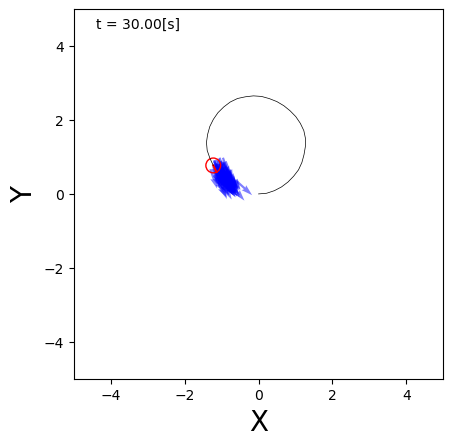

In [40]:
trial(Dict("nn"=>0.01, "no"=>0.02, "on"=>0.03, "oo"=>0.04))